# GraphST

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 11.01.2023
- **Date of Last Modification:** 13.01.2023

- The GraphST source code is available at https://github.com/JinmiaoChenLab/GraphST.
- The corresponding preprint is "Long, Y. et al. DeepST: A versatile graph contrastive learning framework for spatially informed clustering, integration, and deconvolution of spatial transcriptomics. Preprint at https://doi.org/10.1101/2022.08.02.502407".

- The workflow of this notebook follows the tutorial from https://deepst-tutorials.readthedocs.io/en/latest/Tutorial%201_10X%20Visium.html.
- The authors use raw counts as input to GraphST (stored in adata.X). Therefore, we also use raw counts.
- To define the spatial neighborhood graph, the original GraphST paper uses the 3 nearest neighbors of a cell as neighbors and the union of all neighbors is used as final spatial neighborhood graph (the adjacency matrix is made symmetric). We use the same method but vary the number of neighbors between 4, 8, 12, 16 and 20.

## 1. Setup

### 1.1 Import Libraries

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import torch
from GraphST import GraphST
from sklearn import metrics

### 1.2 Define Parameters

In [2]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
latent_key = "graphst_latent"
leiden_resolution = 0.5 # used for Leiden clustering of latent space
random_seed = 0

### 1.3 Run Notebook Setup

In [3]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [5]:
# Run device. By default, the package is implemented on 'cpu'. It is recommended to use GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures/method_benchmarking/{dataset}/graphst"

In [7]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Data

In [8]:
# Load data
adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")

## 3. GraphST Model

Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [11:44<00:00,  1.17s/it]


Optimization finished for ST data!


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


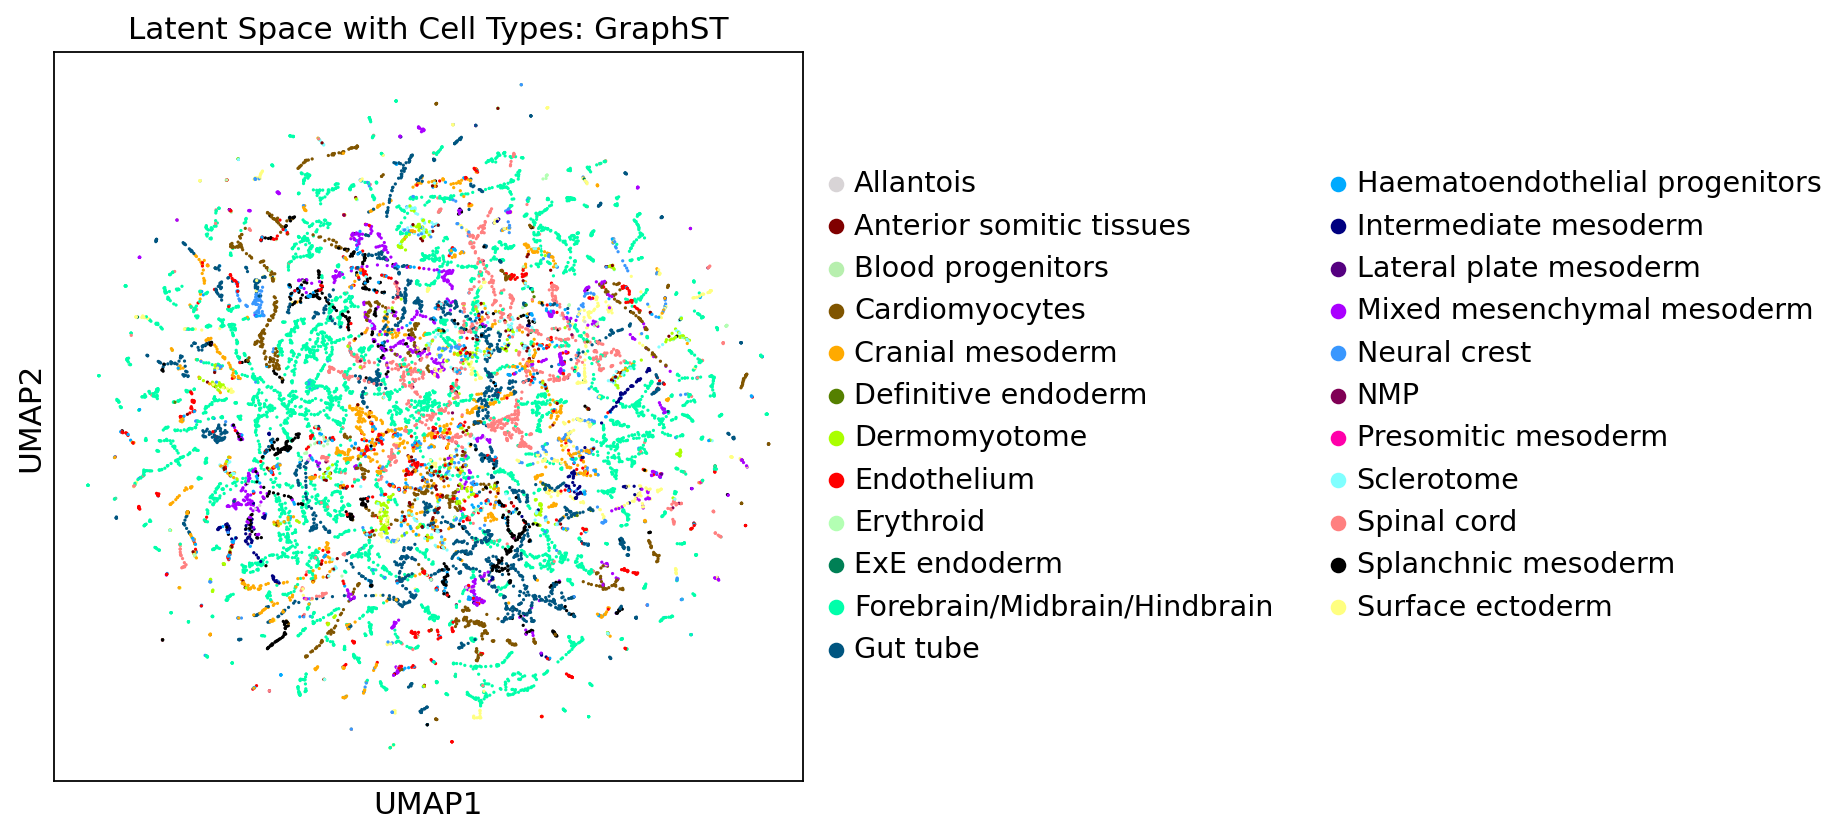

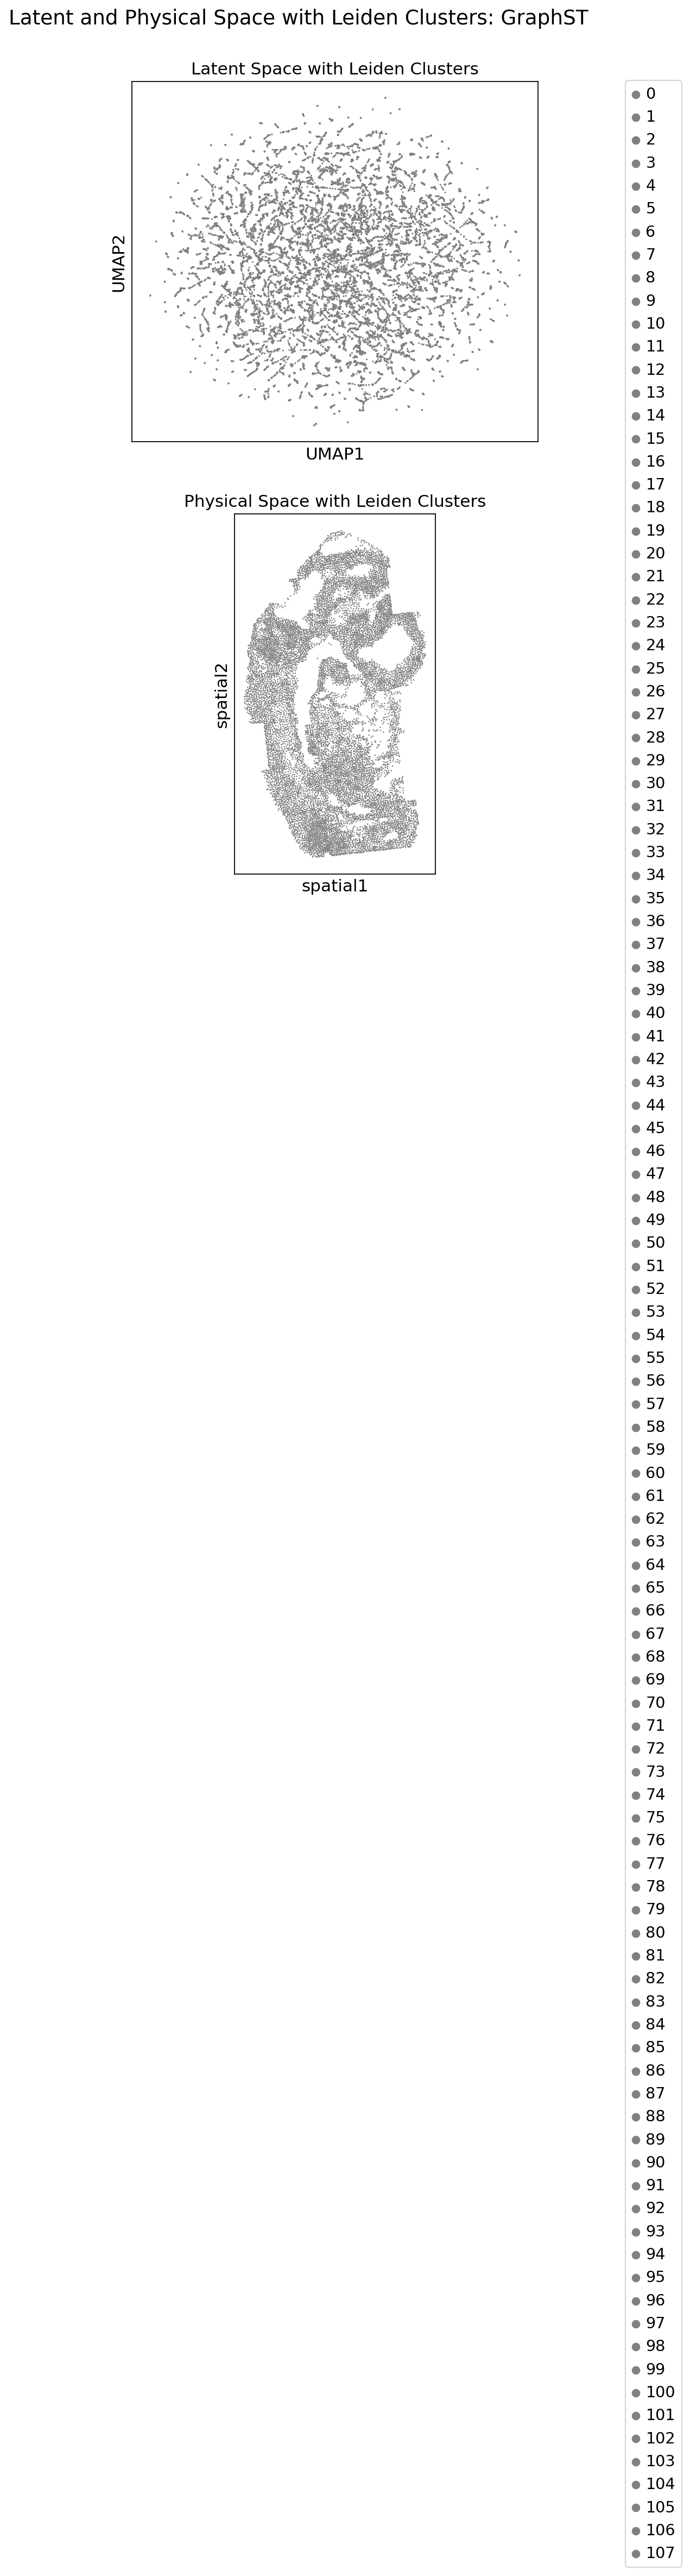

Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [11:58<00:00,  1.20s/it]


Optimization finished for ST data!


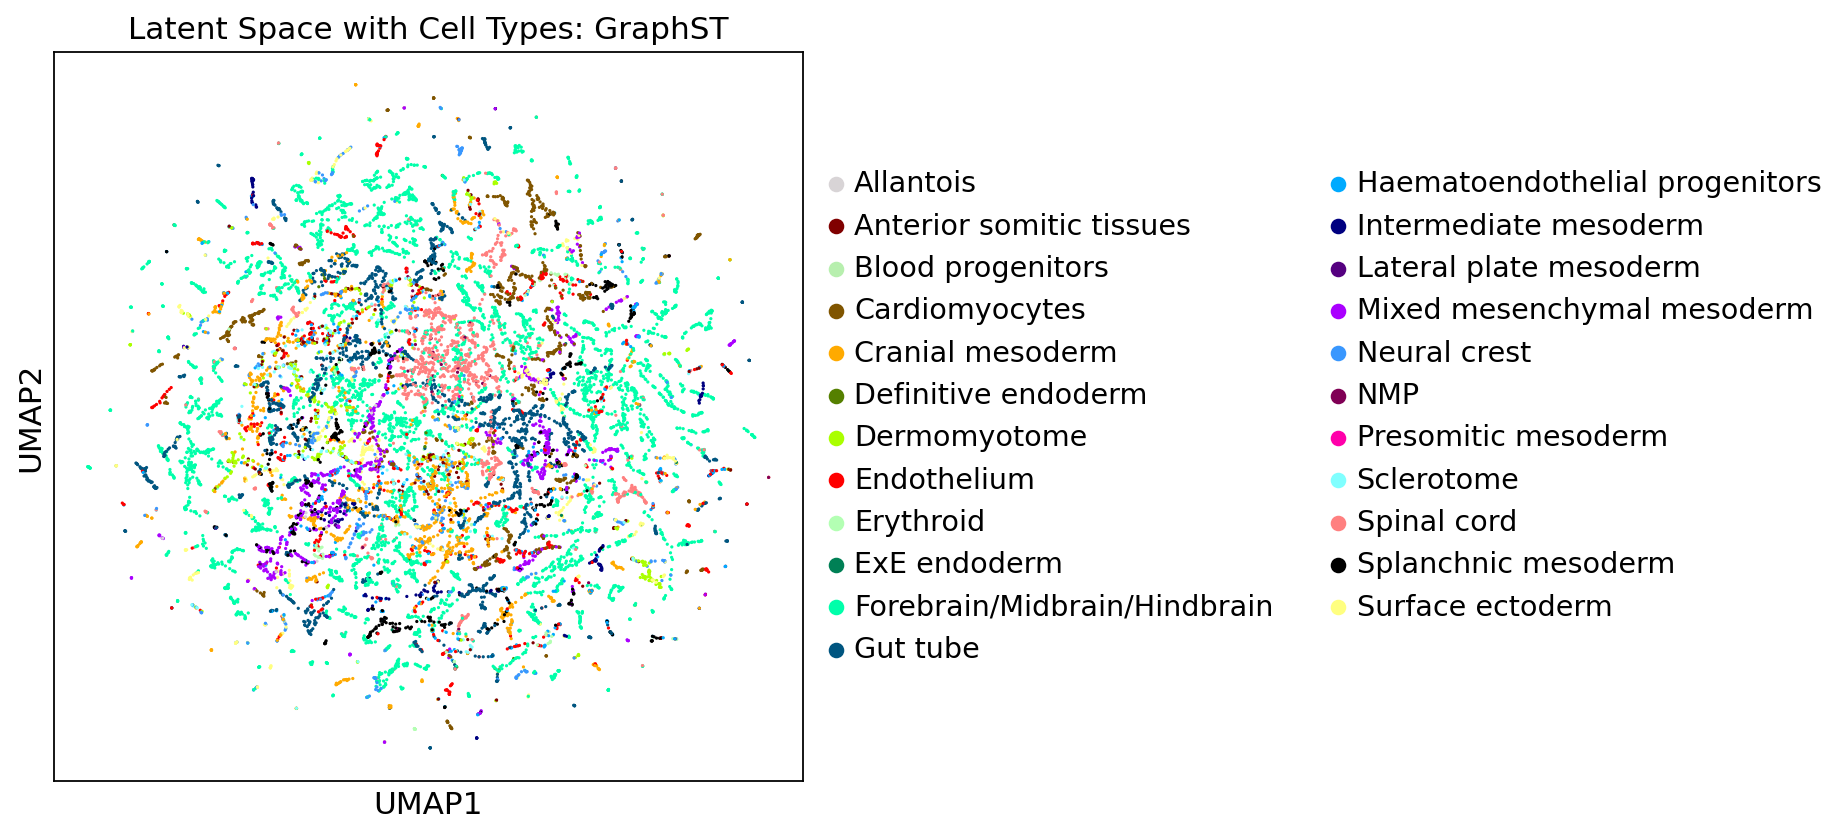

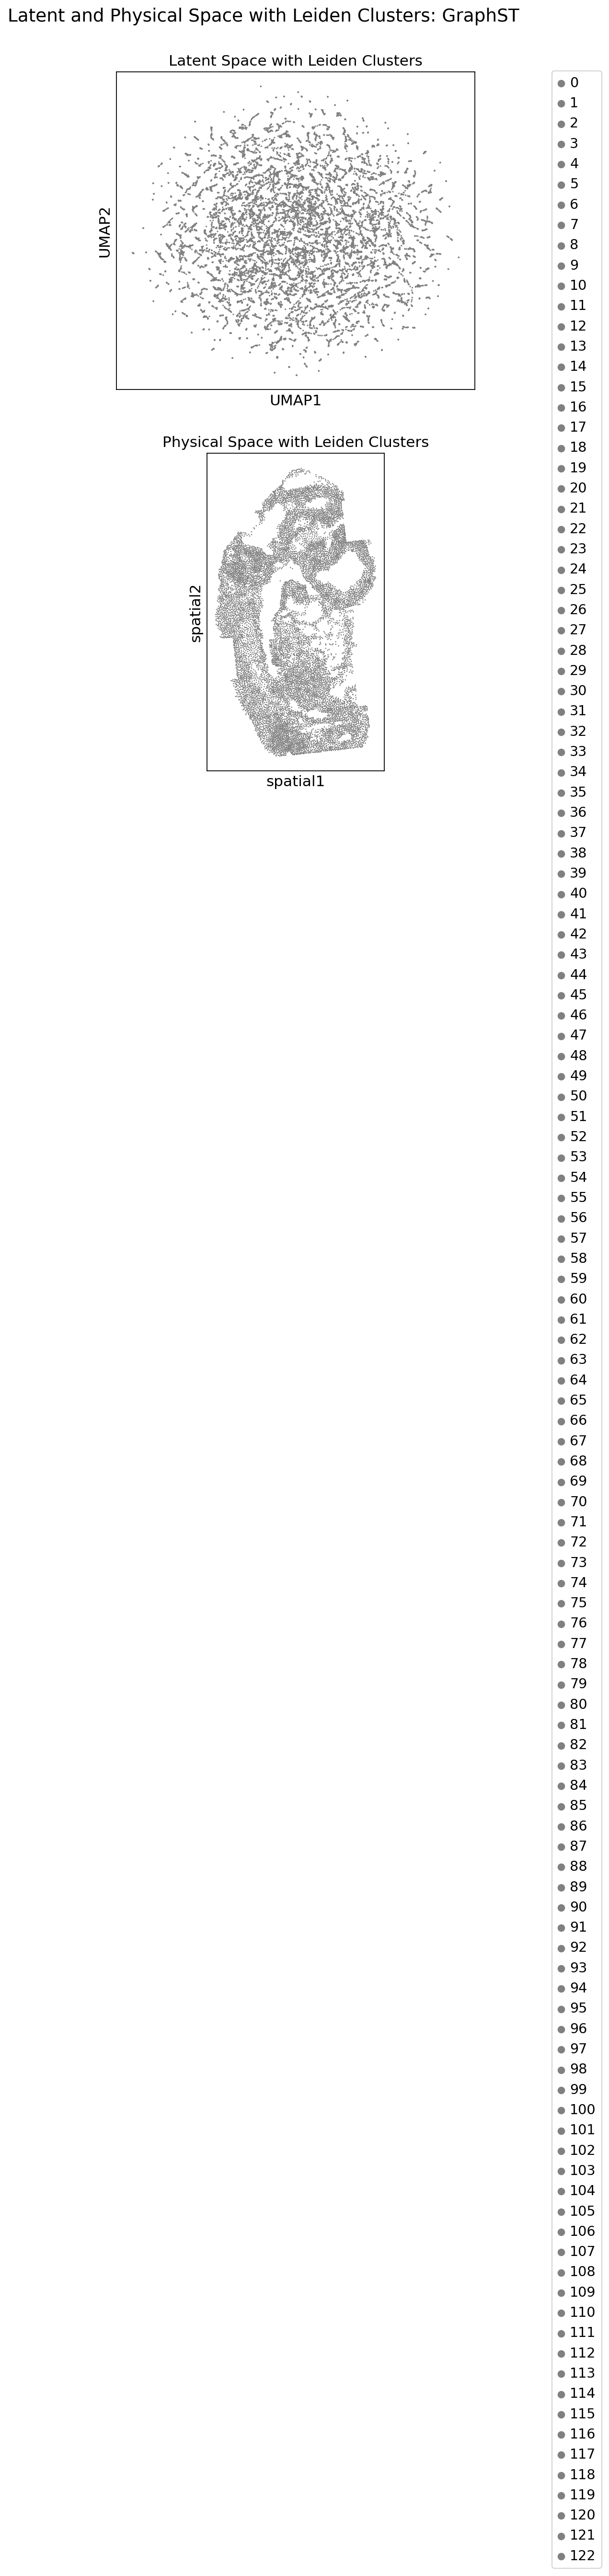

Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [13:50<00:00,  1.38s/it]


Optimization finished for ST data!


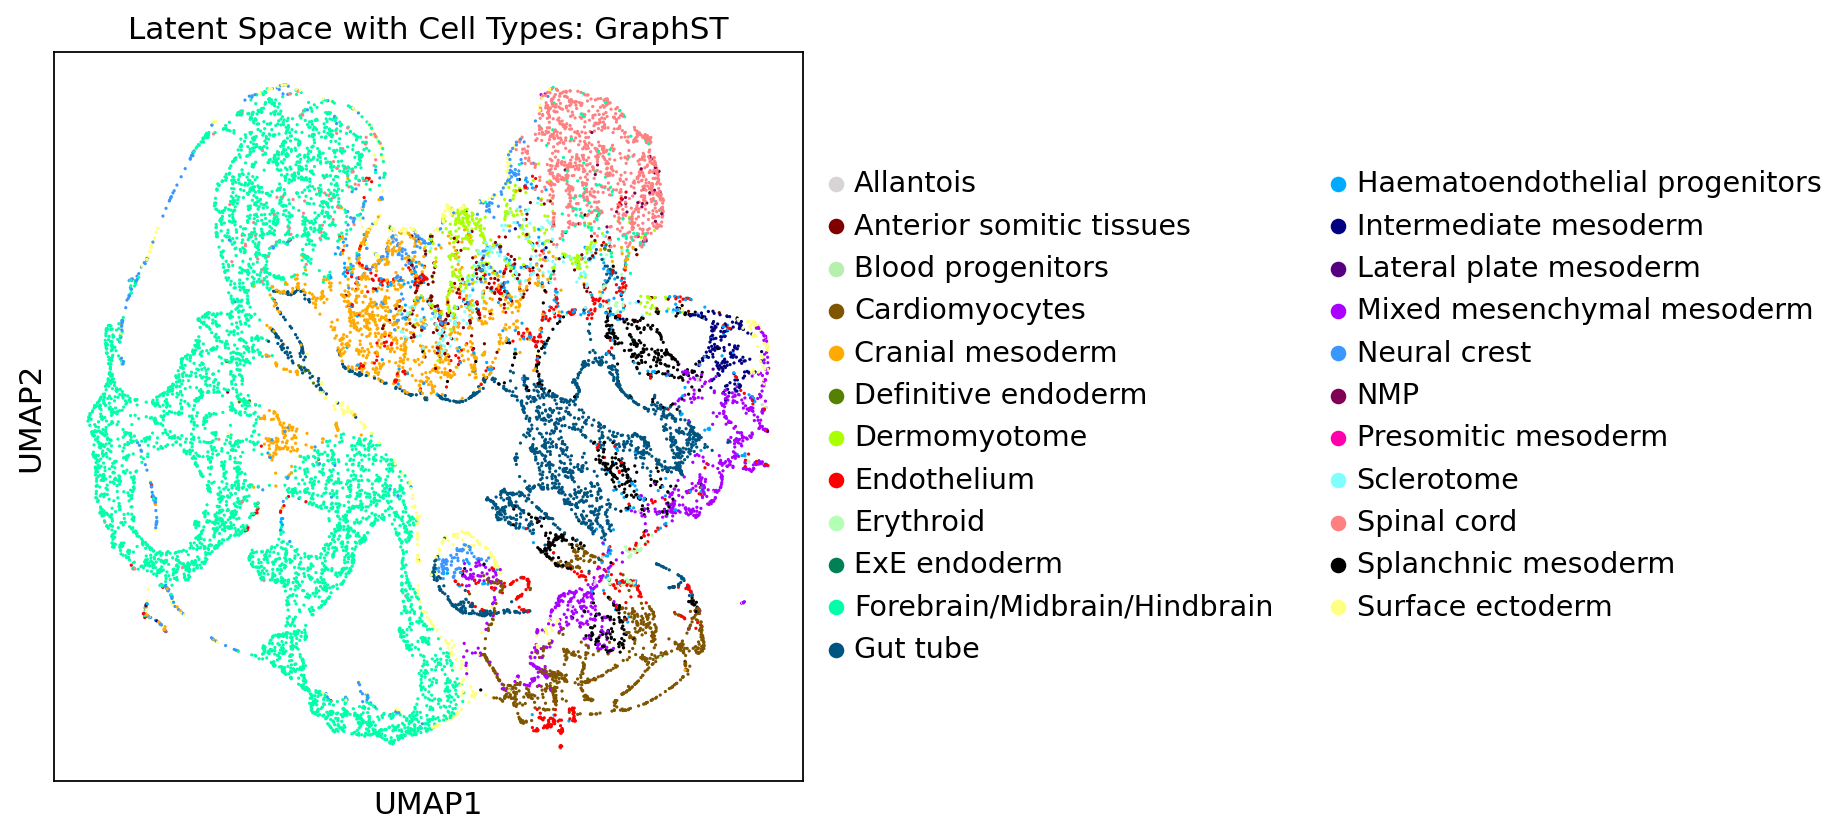

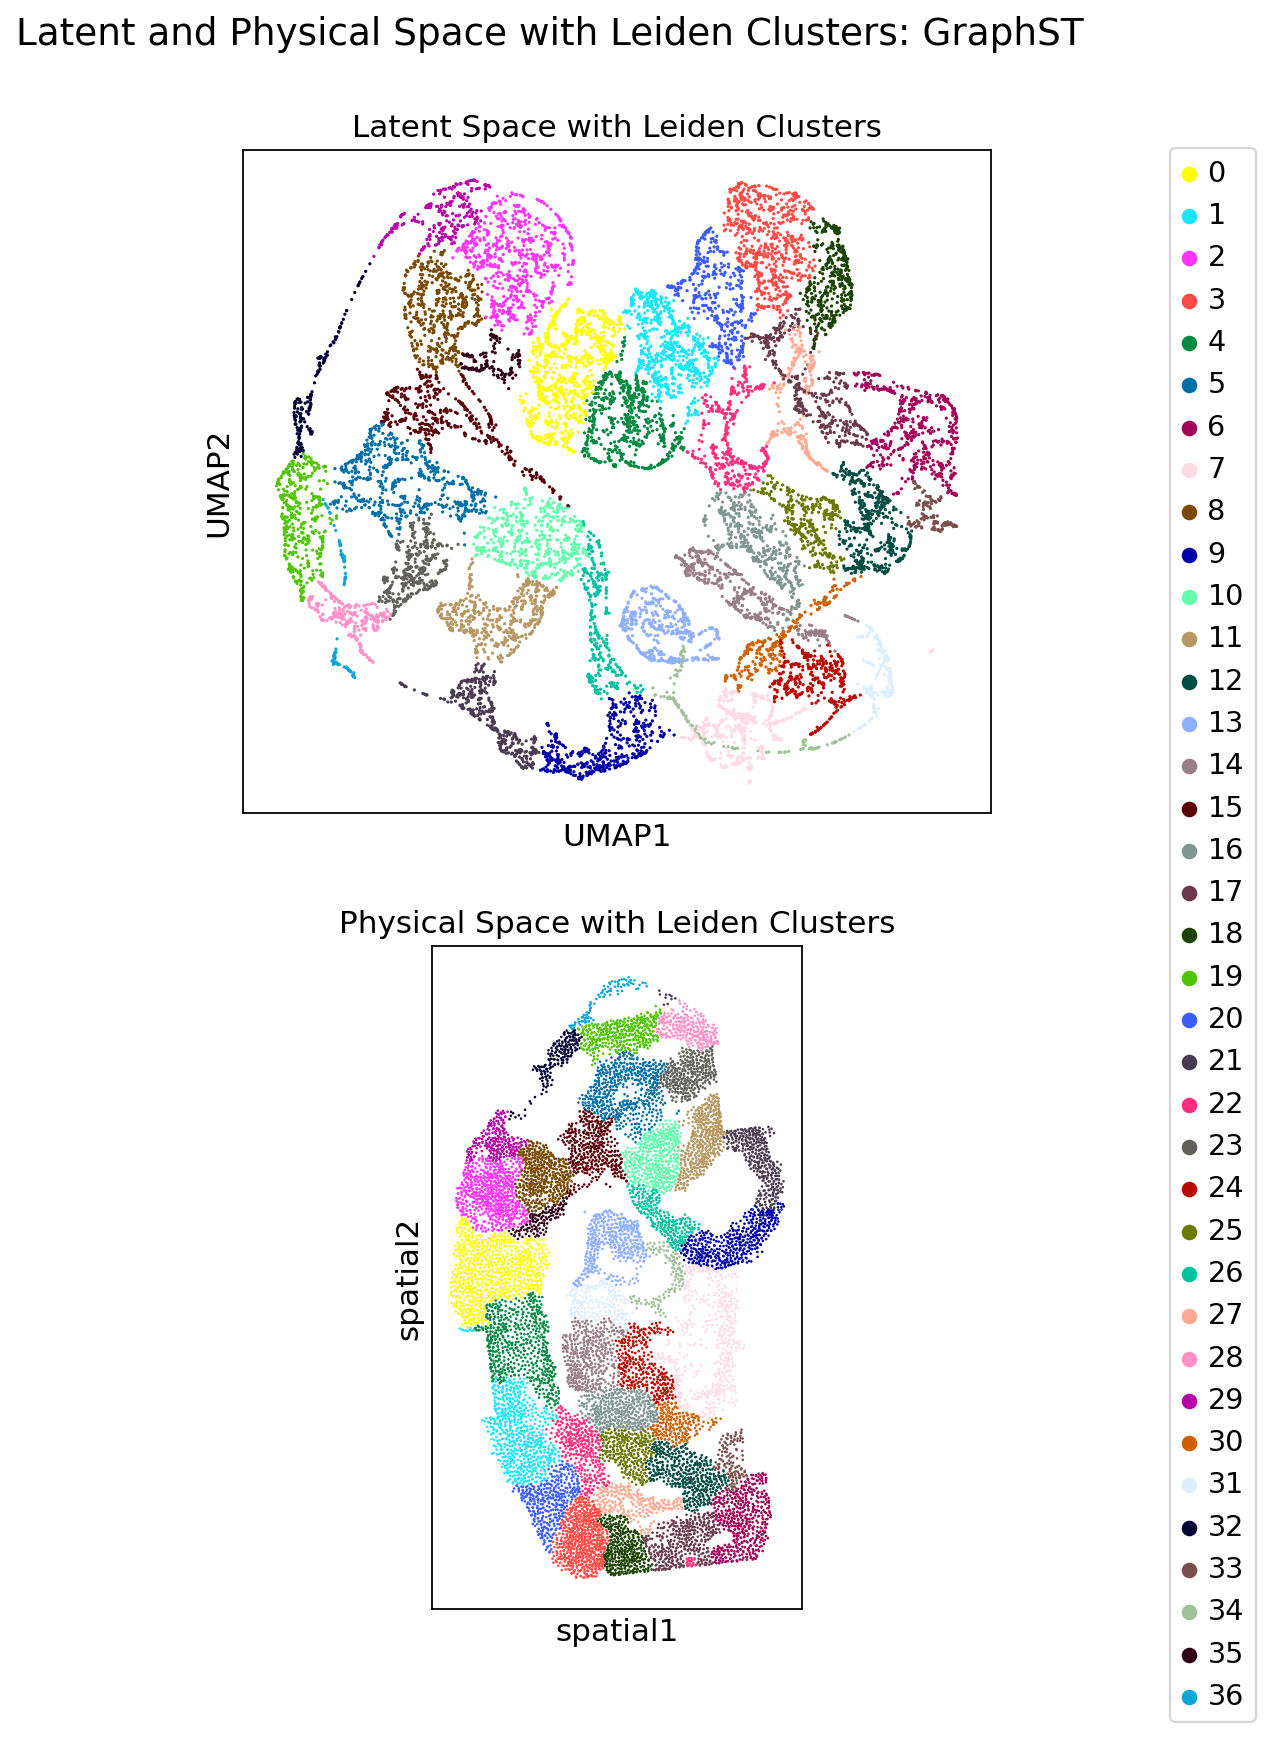

Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [13:07<00:00,  1.31s/it]


Optimization finished for ST data!


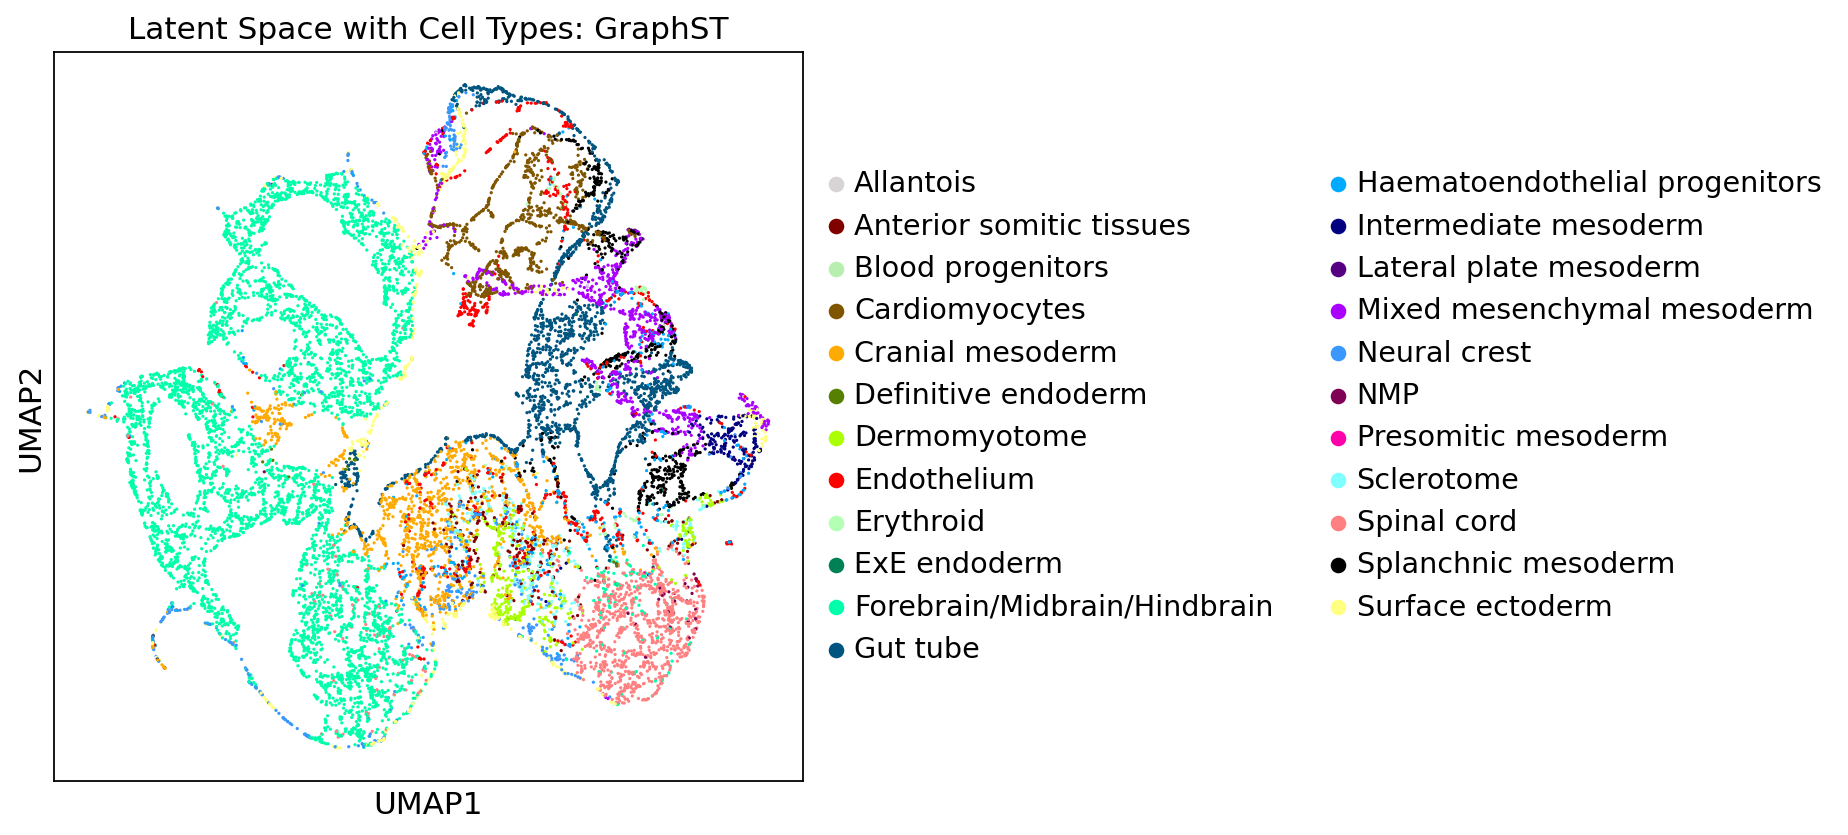

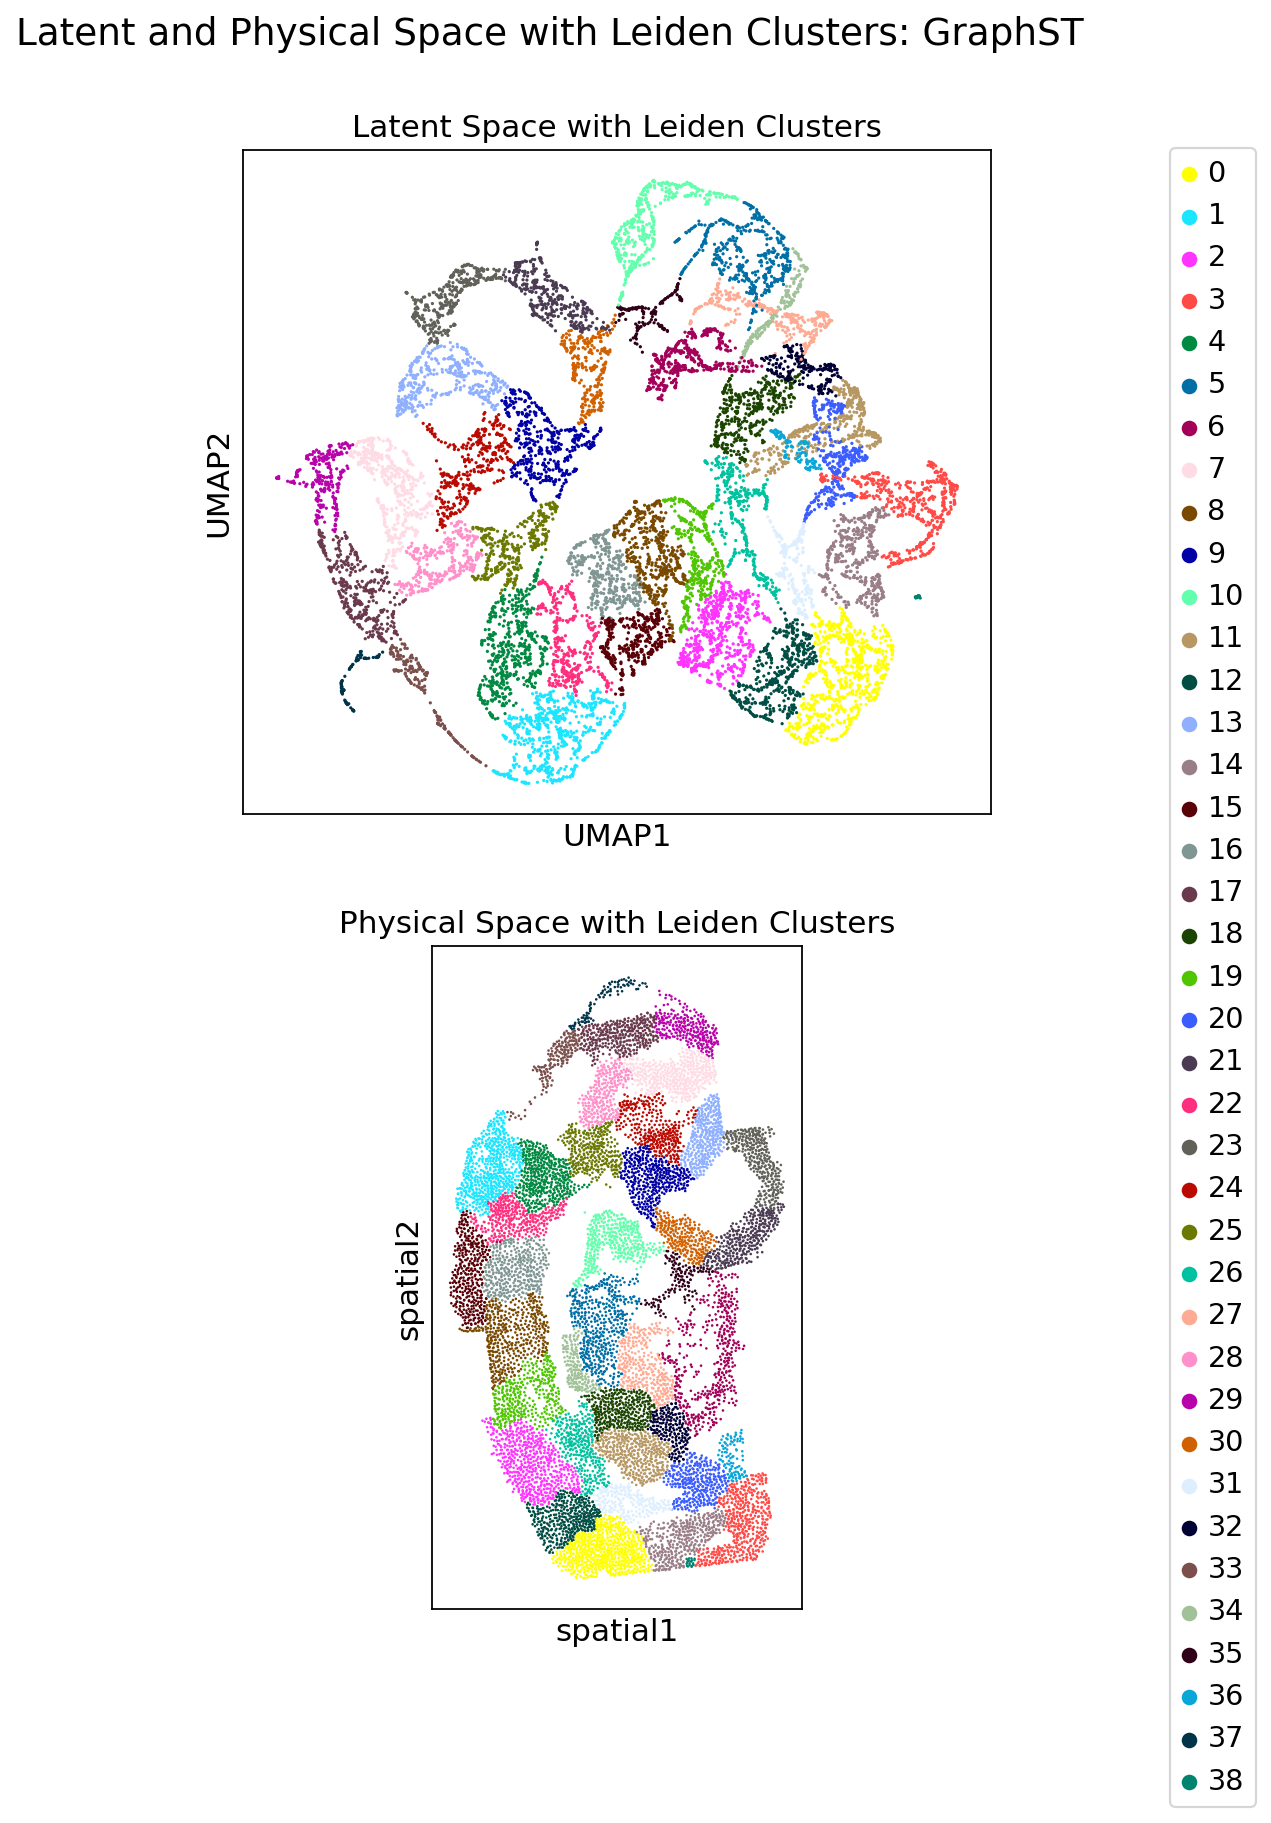

In [ ]:
model_seeds = [0, 1] * 5 # different seeds for the 2 iterations for each 'n_neighbors'

for run_number, n_neighbors in enumerate([4, 4, 8, 8, 12, 12, 16, 16, 20, 20]):
    # Load data
    adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
    
    # Store raw counts in adata.X
    adata.X = adata.layers["counts"].toarray()
    
    # Compute spatial neighborhood graph
    sq.gr.spatial_neighbors(adata,
                            coord_type="generic",
                            spatial_key="spatial",
                            n_neighs=n_neighbors)
    adata.obsm["graph_neigh"] = adata.obsp["spatial_connectivities"]
    adj = adata.obsm["graph_neigh"].toarray()
    adj = adj + adj.T
    adata.obsm["adj"] = np.where(adj>1, 1, adj)
    
    # Define model
    model = GraphST.GraphST(adata,
                            device=device,
                            random_seed=model_seeds[run_number])
    
    # Train model
    adata = model.train()
    
    # Use GraphST latent space for UMAP generation
    sc.pp.neighbors(adata, use_rep="emb", n_neighbors=n_neighbors)
    sc.tl.umap(adata, min_dist=0.3)
    fig = sc.pl.umap(adata,
                     color=[cell_type_key],
                     title="Latent Space with Cell Types: GraphST",
                     return_fig=True)
    fig.savefig(f"{figure_folder_path}/latent_graphst_cell_types_run_{run_number + 1}_{current_timestamp}.png",
                bbox_inches="tight")

    # Compute latent Leiden clustering
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolution,
                 random_state=random_seed,
                 key_added=f"latent_graphst_leiden_{str(leiden_resolution)}")

    # Create subplot of latent Leiden cluster annotations in physical and latent space
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
    title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: GraphST")
    sc.pl.umap(adata=adata,
               color=[f"latent_graphst_leiden_{str(leiden_resolution)}"],
               title=f"Latent Space with Leiden Clusters",
               ax=axs[0],
               show=False)
    sc.pl.spatial(adata=adata,
                  color=[f"latent_graphst_leiden_{str(leiden_resolution)}"],
                  spot_size=0.03,
                  title=f"Physical Space with Leiden Clusters",
                  ax=axs[1],
                  show=False)

    # Create and position shared legend
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.9185))
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()

    # Adjust, save and display plot
    plt.subplots_adjust(wspace=0, hspace=0.2)
    fig.savefig(f"{figure_folder_path}/latent_physical_comparison_graphst_leiden_run_{run_number + 1}_{current_timestamp}.png",
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
    plt.show()

    adata_original.obsm[latent_key + f"_run{run_number + 1}"] = adata.obsm["emb"]
    
    # Store intermediate adata to disk
    adata_original.write(f"{data_folder_path}/{dataset}_graphst.h5ad")
    
# Label all 'gene programs' as active gene programs for subsequent benchmarking
adata_original.uns["graphst_active_gp_names"] = np.array([f"latent_{i}" for i in range(adata_original.obsm["graphst_latent_run1"].shape[1])])

# Store final adata to disk
adata_original.write(f"{data_folder_path}/{dataset}_graphst.h5ad")